In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

olid_data = pd.read_csv("/content/drive/MyDrive/PG_Project_JU /Datasets/OLID.csv")
cyber_troll = pd.read_csv("/content/drive/MyDrive/PG_Project_JU /Datasets/Cyber-Troll.csv")
olid_data.head()

,Text,Label
0,@USER She should ask a few native Americans wh...,1
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,1
2,Amazon is investigating Chinese employees who ...,0
3,"@USER Someone should'veTaken"" this piece of sh...",1
4,@USER @USER Obama wanted liberals &amp; illega...,0


In [ ]:
cyber_troll.head()

,Text,Label
0,Get fucking real dude.,1
1,She is as dirty as they come and that crook ...,1
2,why did you fuck it up. I could do it all day...,1
3,Dude they dont finish enclosing the fucking s...,1
4,WTF are you talking about Men? No men thats n...,1


In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess1_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
cyber_troll['Text'] = cyber_troll['Text'].apply(preprocess1_text)

In [ ]:
print(cyber_troll.head())

                                                Text  Label
0                              get fucking real dude      1
1  dirty come crook rengel dems fucking corrupt j...      1
2  fuck could day let hour ping later sched writi...      1
3  dude dont finish enclosing fucking shower hate...      1
4         wtf talking men men thats menage thats gay      1


In [ ]:
labels = ['Label']

In [ ]:

def load_glove_embeddings(glove_path):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

glove_path = "/content/drive/MyDrive/PG_Project_JU /Datasets/glove.6B.100d.txt"
glove_embeddings = load_glove_embeddings(glove_path)


def get_glove_embedding(sentence):
    words = sentence.split()
    embeddings = [glove_embeddings[word] for word in words if word in glove_embeddings]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(100)


cyber_troll['glove_embeddings'] = cyber_troll['Text'].apply(get_glove_embedding)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.sequence import pad_sequences
import numpy as np
X = cyber_troll['Text']
y= cyber_troll[labels]

bow_vectorizer = CountVectorizer(max_features=10000)
X_bow = bow_vectorizer.fit_transform(X)

tfidf_transformer = TfidfTransformer()
X_tfidf_bow = tfidf_transformer.fit_transform(X_bow)

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)

svm_model.fit(X_tfidf_bow,y.values.ravel())

svm_features = svm_model.decision_function(X_tfidf_bow)

svm_features = np.expand_dims(svm_features, axis=-1)

In [ ]:
print(svm_features)

[[ 0.02873887]
 [ 0.10793236]
 [-1.00000065]
 ...
 [ 1.06122732]
 [ 1.34650968]
 [-1.22295854]]


In [ ]:
X_combined = np.concatenate([np.vstack(cyber_troll['glove_embeddings']), svm_features], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_combined, cyber_troll[labels], test_size=0.2, random_state=42)

In [ ]:
print(cyber_troll['glove_embeddings'])

0        [0.2899825, 0.161555, 0.58119, -0.79909754, -0...
1        [-0.18105319, 0.29501164, 0.49518996, -0.87755...
2        [-0.2058709, 0.038032003, 0.16168061, -0.12545...
3        [0.05821299, 0.19408746, 0.29457766, -0.412489...
4        [0.5950463, 0.3413884, 0.2291615, -0.19328675,...
                               ...                        
19996    [0.16881062, 0.23651667, 0.40208998, -0.317370...
19997    [0.028834885, 0.12630828, 0.42027184, -0.33914...
19998    [0.35715002, 0.039875, 0.6434235, -0.249055, -...
19999    [-0.13874826, 0.2900175, 0.495825, -0.3491, 0....
20000    [0.33237335, 0.5960733, 0.444255, -0.24391466,...
Name: glove_embeddings, Length: 20001, dtype: object


In [ ]:
print(X_combined)

[[ 0.2899825   0.16155501  0.58118999 ...  0.10459249  0.17204998
   1.00000163]
 [-0.18105319  0.29501164  0.49518996 ...  0.21169446  0.23153563
   1.00025719]
 [-0.2058709   0.038032    0.16168061 ...  0.16456175  0.25827098
   1.00000072]
 ...
 [ 0.35715002  0.039875    0.6434235  ... -0.0097335   0.007155
  -0.99995024]
 [-0.13874826  0.29001749  0.49582499 ...  0.49875724  0.38883448
  -1.05779479]
 [ 0.33237335  0.59607333  0.44425499 ...  0.30274633  0.39799938
  -1.00039766]]


In [ ]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_combined.shape[1], 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(len(labels), activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 90s 217ms/step - accuracy: 0.8865 - loss: 0.2712 - val_accuracy: 0.9834 - val_loss: 0.0731
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 83s 208ms/step - accuracy: 0.9861 - loss: 0.0673 - val_accuracy: 0.9834 - val_loss: 0.0672
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 146s 219ms/step - accuracy: 0.9847 - loss: 0.0659 - val_accuracy: 0.9837 - val_loss: 0.0668
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 137s 208ms/step - accuracy: 0.9850 - loss: 0.0627 - val_accuracy: 0.9837 - val_loss: 0.0677
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 147s 220ms/step - accuracy: 0.9850 - loss: 0.0674 - val_accuracy: 0.9837 - val_loss: 0.0676
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 87s 216ms/step - accuracy: 0.9840 - loss: 0.0647 - val_accuracy: 0.9844 - val_loss: 0.0642
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 142s 217ms/step - accuracy: 0.9842 - loss: 0.0673 - val_accuracy: 0.9837 - val_loss: 0.0648
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 141s 216ms/step - accuracy: 0.9861 - loss: 0.0568 

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_combined.shape[1], 1)),
    MaxPooling1D(pool_size=1),
    Conv1D(filters=128, kernel_size=1, activation='relu'),
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(labels), activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.9115 - loss: 0.2205 - val_accuracy: 0.9819 - val_loss: 0.0625
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9848 - loss: 0.0564 - val_accuracy: 0.9828 - val_loss: 0.0569
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9836 - loss: 0.0518 - val_accuracy: 0.9828 - val_loss: 0.0551
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9858 - loss: 0.0458 - val_accuracy: 0.9828 - val_loss: 0.0510
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.9860 - loss: 0.0398 - val_accuracy: 0.9822 - val_loss: 0.0517
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9880 - loss: 0.0373 - val_accuracy: 0.9816 - val_loss: 0.0507
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.9876 - loss: 0.0382 - val_accuracy: 0.9806 - val_loss: 0.0522
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9895 - loss: 0.0361 - val_accurac

In [ ]:
from keras.layers import Bidirectional
bilstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_combined.shape[1], 1)),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bilstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 209s 509ms/step - accuracy: 0.9363 - loss: 0.1838 - val_accuracy: 0.9794 - val_loss: 0.0900
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 253s 486ms/step - accuracy: 0.9853 - loss: 0.0702 - val_accuracy: 0.9809 - val_loss: 0.0777
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 209s 504ms/step - accuracy: 0.9829 - loss: 0.0769 - val_accuracy: 0.9812 - val_loss: 0.0744
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 202s 503ms/step - accuracy: 0.9842 - loss: 0.0659 - val_accuracy: 0.9772 - val_loss: 0.0945
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 196s 488ms/step - accuracy: 0.9826 - loss: 0.0777 - val_accuracy: 0.9794 - val_loss: 0.0782
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 203s 508ms/step - accuracy: 0.9819 - loss: 0.0818 - val_accuracy: 0.9784 - val_loss: 0.0761
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 260s 504ms/step - accuracy: 0.9821 - loss: 0.0756 - val_accuracy: 0.9822 - val_loss: 0.0820
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 203s 507ms/step - accuracy: 0.9852 - loss: 0.06

126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step


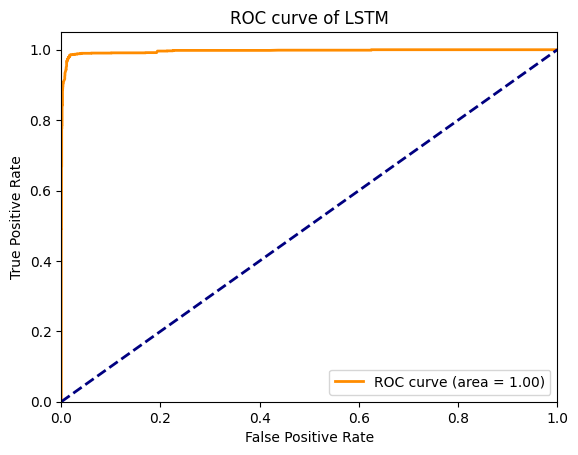

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_prob = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of LSTM')
plt.legend(loc="lower right")
plt.show()


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


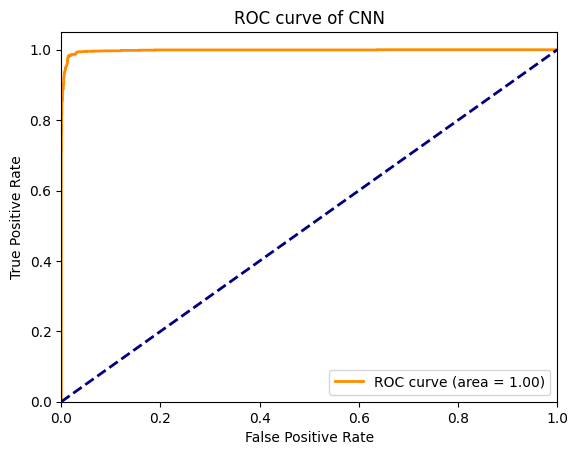

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_pred_prob = cnn_model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of CNN')
plt.legend(loc="lower right")
plt.show()


126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step


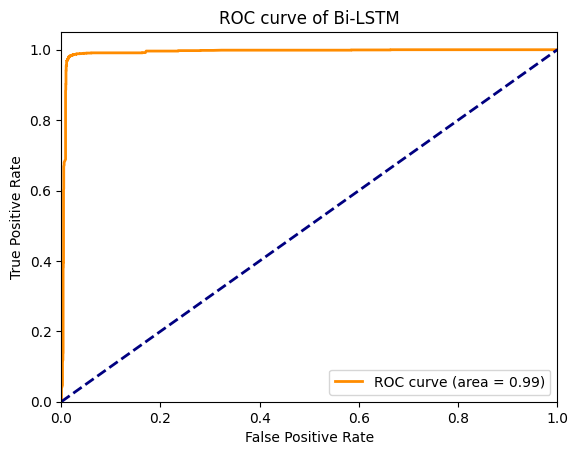

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_prob = bilstm_model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Bi-LSTM')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("LSTM Model Performance:\n", classification_report(y_test, y_pred))

print("Test Accuracy:", accuracy_score(y_test, y_pred))


126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step
LSTM Model Performance:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      2424
           1       0.98      0.98      0.98      1577

    accuracy                           0.98      4001
   macro avg       0.98      0.98      0.98      4001
weighted avg       0.98      0.98      0.98      4001

Test Accuracy: 0.9822544363909023


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

y_pred_prob = cnn_model.predict(X_test)
y_pred_cnn = (y_pred_prob > 0.5).astype(int)


print("CNN Model Performance:\n", classification_report(y_test, y_pred_cnn))


print("Test Accuracy:", accuracy_score(y_test, y_pred_cnn))

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
CNN Model Performance:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2424
           1       0.98      0.98      0.98      1577

    accuracy                           0.98      4001
   macro avg       0.98      0.98      0.98      4001
weighted avg       0.98      0.98      0.98      4001

Test Accuracy: 0.9835041239690078


In [ ]:
y_pred_prob = bilstm_model.predict(X_test)
y_pred_bi = (y_pred_prob > 0.5).astype(int)


print("Bi-LSTM Model Performance:\n", classification_report(y_test, y_pred_bi))


print("Test Accuracy:", accuracy_score(y_test, y_pred_bi))

126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step
Bi-LSTM Model Performance:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      2424
           1       0.98      0.98      0.98      1577

    accuracy                           0.98      4001
   macro avg       0.98      0.98      0.98      4001
weighted avg       0.98      0.98      0.98      4001

Test Accuracy: 0.9827543114221444


Confusion Matrix:
[[2386   38]
 [  33 1544]]


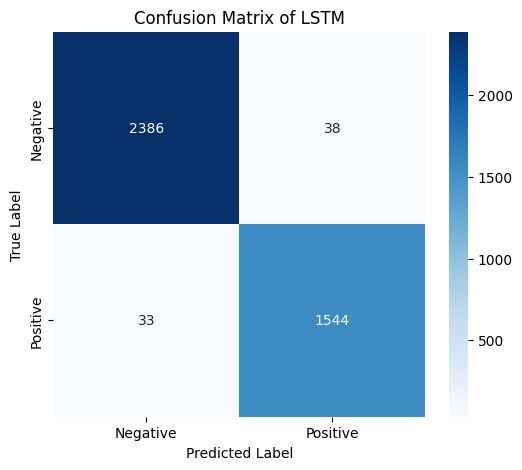

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of LSTM")
plt.show()


Confusion Matrix:
[[2391   33]
 [  33 1544]]


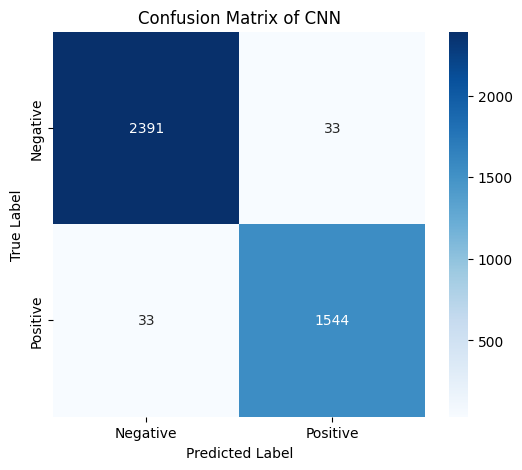

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred_cnn)

print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of CNN")
plt.show()


Confusion Matrix:
[[2387   37]
 [  32 1545]]


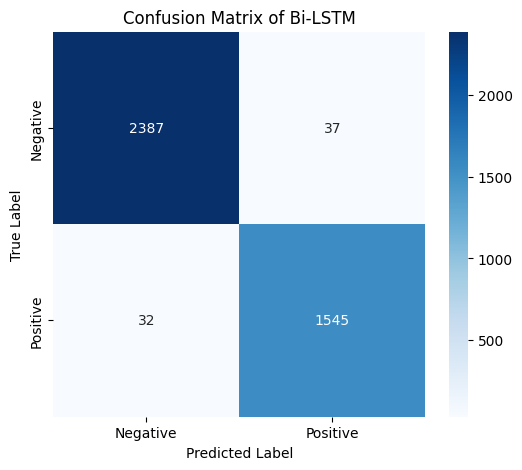

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_bi)

print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Bi-LSTM")
plt.show()


In [ ]:
def classify_text_CNN(text):
    text_processed = preprocess1_text(text)


    glove_embedding = get_glove_embedding(text_processed)

    text_bow = bow_vectorizer.transform([text_processed])
    text_tfidf = tfidf_transformer.transform(text_bow)
    svm_feature = svm_model.decision_function(text_tfidf)

    combined_feature = np.concatenate([glove_embedding, [svm_feature[0]]]).reshape(1, -1)

    prediction = cnn_model.predict(combined_feature)

    return (prediction > 0.5).astype(int)

In [ ]:
example=str(input("Enter the text: "))

CNN_prediction = classify_text_CNN(example)
print(f"CNN Prediction: {CNN_prediction}")

Enter the text: i love you as a friend 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
CNN Prediction: [[0]]
